int32
[1220 1620]
[12 32]
[1208 1588]
[604 794]


C:\Users\AVazquez\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:215: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


1030.422026823895
substract blocked
943.0467102590352
(700, 328) (700, 426) (700, 800)
ratio
0.91520433929952


C:\Users\AVazquez\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:263: RuntimeWarning: divide by zero encountered in log10
C:\Users\AVazquez\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:305: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


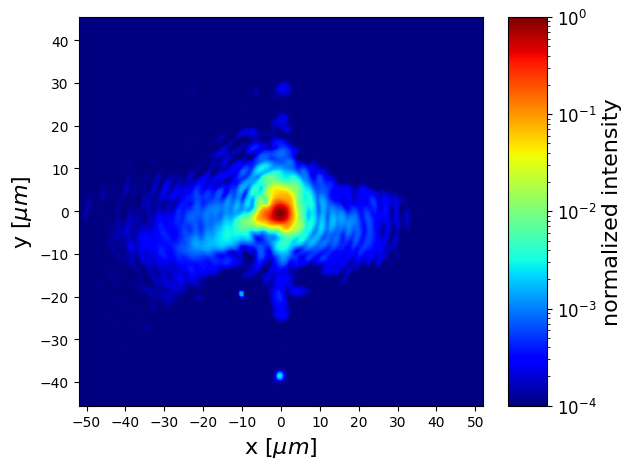

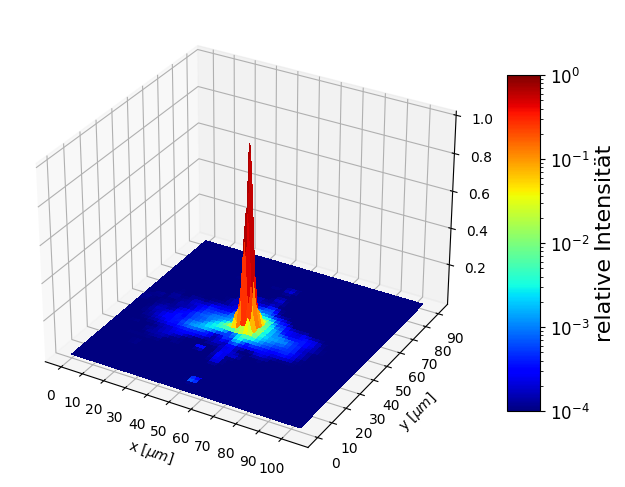

C:\Users\AVazquez\AppData\Local\Programs\Python\Python37\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:113: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


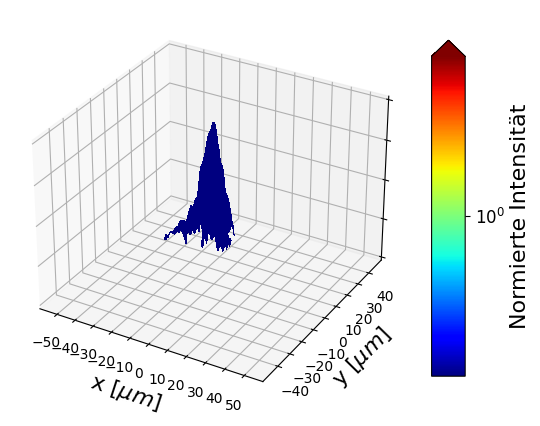

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 18 14:02:51 2018

@author: assenb05
translation: FinnKohrell
          
Script to create HDR images from single captures

needed:
    - N  single captures in tif or png format with name: "_setting_X."
      Setting 0 represents the image with strongest reduction / weakest intensity
    - focal position (x,y) in pixels (narrow side of the image first) for every single capture
    - calibrated relative transmission for every Setting (relative in relation to highest transmission)
    - mean background-grey value for every single capture
    - length calibration px/um of the image series
    - maximum grey value of the image with highest intensity reduction / most weakened image
    
Creates/returns upon request:
    - HDR image
    - in addition upon request:
        - normalized, logarithmic, cropped, smoothed (locally averaged) HDR image
        - logarithmic colormesh graoh
        - 3D surface plot over selected area
"""

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatter 
from matplotlib.ticker import LogLocator
from matplotlib import rcParams
rcParams['figure.subplot.bottom'] = 0.14

import os
# %matplotlib 
#----------------------------------------------------------------
# working directory
path = os.getcwd()
subfolder = '\lotti_images'    # target directory/subfolder with single captures
os.chdir(path+subfolder)

#---------------------------------------------------------------
def smooth(im, px=1):
    """
    returns mean grey values for every pixel averaged over a square with dimension 2*px+1 around each pixel in "im"
    returns result as array of same dimension as "im"
    """
    imsmooth = np.ones_like(im)     # creating outputarray
    x, y = np.nonzero(imsmooth)     # array of coordinates 
    for i in np.arange(len(x)):     # averaging over squares 2px+1^2
        imsmooth[x[i], y[i]] = np.sum(im[x[i]-px:x[i]+px, 
                                      y[i]-px:y[i]+px])/((2*px+1)**2)
    return imsmooth
#--------------------------------------------------------------    
# define output settings
smoothing, px = True, 4             # beware, time consuming!
normieren = True           
logarithmieren = True
cuttosize, resolution = True, np.array([700, 800])  # reduce to x*y Pixel #************************
plotten = True                              # colormesh Plot
plot3d, res3d = True, np.array([700,800])   # 3D surface Plot (x*y Pixel)#************************

#--------------------------------------------------------------
# Input-settings
imageformat = "png"     # image format
name = "Cropped"           # image name with convention: Name_setting_X_1#************************ check

Maxsat = 62000          # Maximum grey value (larger than maximum in first Setting)

kalib = 0.13            # um/px

N = 4                   # total number of settings

# order corresponds to rising transmission/lowering reduction
# all input arrays according to naming condition [setting1, setting2, setting3,...]
hintergrund = np.array([608.5, 615.6, 616.1, 657.6])       # mean background
transm = np.array([0.0319, 0.1884, 0.2569, 1])          # relative Transmission 


# Position of focal peak in x and y coordinates (px) in 2D Array
fok = np.array([[608, 605, 605, 605], 
                [825, 825, 825, 825]])  #************************
                # possibly correction by hand, to ensure as little intensity jumps as possible without smooting in HDR image
# fok = np.array([[228, 228, 228, 228], 
#                 [230, 230, 230, 230]])
                
                
#-----------------------------------------------------------------------
# main code

# first Setting as reference
im1 = np.asarray(Image.open("{0}Mini_setting_1_1.{1}".format(name, imageformat)))#************************Check
# im1 = np.pad(im1, ((0,1),(0,1)), 'constant')

print(im1.dtype)                        
res = np.array(im1.shape)          # image resolution
print(res)
abschneiden = np.array([max(abs(fok[0]-res[0]/2)), 
                        max(abs(fok[1]-res[1]/2))]).astype(int)+1
                        # how much has to bet cut to account for different focal positions
                        # +1 to be safe
print(2*abschneiden)
newres = res - 2*abschneiden        # resolution of cropped image
b = newres//2 
print(newres)#             
print(b)

# im_stack = np.zeros(np.append(newres+1, N))   #generating full array

im_stack = np.zeros(np.append(newres+1, N))   #generating full array

# cut and implememt first Setting
im_stack[:, :, 0] = im1[fok[0,0]-b[0]:fok[0,0]+b[0]+1, 
                        fok[1,0]-b[1]:fok[1,0]+b[1]+1] - hintergrund[0]                        # implement setting 1 into full array

for i in np.arange(1, N):       # implement of residual settings
    imtemp = np.asarray(Image.open(
            "{0}Mini_setting_{1}_1.{2}".format(name, i+1, imageformat)))#************************Check
    im_stack[:,:,i] =  imtemp[fok[0,i]-b[0]:fok[0,i]+b[0]+1, 
                              fok[1,i]-b[1]:fok[1,i]+b[1]+1] - hintergrund[i]

for i in reversed(np.arange(N)):    # Analysis
    # check settings in reverse

    a = im_stack[:,:,i]             # choose active layer
    im_stack[a<=Maxsat, :i] = 0     # get rid of signal ion all settings with less transmission               
    im_stack[a>Maxsat, i] = 0       # cut saturation
    
    im_stack[:,:,i] = (im_stack[:,:,i]/transm[i])  # correct reduction
    
    if i<N-1:               # correct for remaining offset between layers
        im_stack[im_stack[:,:,i]>0,i] = (im_stack[im_stack[:,:,i]>0,i]+ 
                                        np.amax(im_stack[:,:, i+1])-
                                        np.amin(im_stack[im_stack[:,:,i]>0,i]))
    output = Image.fromarray(im_stack[:,:,i])
    output.save("a{}.tif".format(i))    
    
# sum over single captures, average grey values if counted multiple times
hdr = np.sum(im_stack, axis=2)/np.count_nonzero(im_stack, axis=2)
hdr_original = hdr

output= Image.fromarray(hdr_original)
output.save("hdr_original.tif")

#--------------------------------------------------------------
# further examination and saving

if cuttosize:               # cut to relevant area
    hdr = hdr[hdr.shape[0]//2+1-resolution[0]//2:
                  hdr.shape[0]//2+1+resolution[0]//2,
              hdr.shape[1]//2+1-resolution[1]//2:
                  hdr.shape[1]//2+1+resolution[1]//2]

if smoothing:               # smoothing of HDR image
    hdr = smooth(hdr, px=px)      

#hdr = hdr-np.amax(hdr)*1e-4            # limit dynamic range
hdr[hdr<np.amax(hdr)*1e-4]=np.max(hdr)*1e-4


hdr_norm = hdr/np.amax(hdr)             # normalize
output = Image.fromarray(hdr_norm)      # saved normalized HDR image
output.save("hdr_norm.tif")  

if logarithmieren:                      # make logarithmic
    hdr[hdr<1]=1                        # remove negative signal
    #hdr = hdr/np.amax(hdr)
    hdr_log = np.log10(hdr)

    output = Image.fromarray(hdr_log)   # save HDR image
    output.save("hdr_log.tif") 


#----------------------------------------------------------------
# Plots

if plotten:
    x = np.arange(-resolution[1]/2, resolution[1]/2)*kalib
    y = np.arange(-resolution[0]/2, resolution[0]/2)*kalib
    xaxis, yaxis = np.meshgrid(x, y)

    plt.figure(0)
    plt.pcolormesh(xaxis, yaxis, hdr_norm, cmap='jet', 
                   norm=LogNorm(vmin=np.amax(hdr_norm)*1e-4,
                                vmax=np.amax(hdr_norm)))
    #plt.axes().set_aspect('equal')
    plt.xlabel(r'x [$\mu m$]',fontsize=16)
    plt.ylabel(r'y [$\mu m$]',fontsize=16)
    plt.xticks(np.arange(10*np.ceil(x[0]/10), 10*np.floor(x[-1]/10+1), 10))
    plt.yticks(np.arange(10*np.ceil(y[0]/10), 10*np.floor(y[-1]/10+1), 10))
    cbar = plt.colorbar( shrink=1.0, aspect=10)
    cbar.set_label('normalized intensity', fontsize=16)
    cbar.ax.tick_params(labelsize=12)
    
    plt.tight_layout()
    plt.savefig('hdr_color.tif',format='tif')

if plot3d:
   # further cutting of the plot and generation of 3d graph
   
   # selection of raw data
   hdr = hdr_norm[hdr.shape[0]//2-res3d[0]//2:hdr.shape[0]//2+res3d[0]//2,
             hdr.shape[1]//2-res3d[1]//2:hdr.shape[1]//2+res3d[1]//2]
   
   x = np.arange(hdr.shape[1])*kalib
   y = np.arange(hdr.shape[0])*kalib
   xaxis, yaxis = np.meshgrid(x, y)
   
   fig = plt.figure(2)
   
   ax = fig.gca(projection='3d')
   surface = ax.plot_surface(xaxis, yaxis, hdr, cmap="jet", 
                             norm=LogNorm(vmin=np.amax(hdr)*1e-4,
                                          vmax=np.amax(hdr)), 
                             linewidth=0, antialiased=False)
                             
   #cset=ax.contour(xaxis, yaxis, hdr, zdir='x', offset = np.amin(x), cmap="grey")

   ax.set_xlabel(r'x [$\mu m$]')
   ax.xaxis.set_ticks(np.arange(x[0], x[-1], 10))
   ax.set_ylabel(r'y [$\mu m$]')
   ax.yaxis.set_ticks(np.arange(y[0], y[-1], 10))

   cbar = fig.colorbar(surface, shrink = 0.7, aspect=10)
   cbar.set_label('relative Intensität', fontsize=16)
   cbar.ax.tick_params(labelsize=12)
#    
#    cbar.set_ticks([np.amax(hdr)/3, np.amax(hdr)*2/3, np.amax(hdr)])
#    cbar.set_ticklabels(['1e-2','1e-1', '1e0'])
   plt.tight_layout()
   plt.subplots_adjust(bottom=10, top=11)
   #plt.savefig('hdr_3d.png', format='png')    # doesnt really work
   

#    
if plot3d:
    # further cutting of the plot and generation of 3d graph
    hdr = hdr_norm[hdr.shape[0]//2-res3d[0]//2:hdr.shape[0]//2+res3d[0]//2,
              hdr.shape[1]//2-res3d[1]//2:hdr.shape[1]//2+res3d[1]//2]
    #hdr = hdr/np.amax(hdr)
    #hdr[hdr<np.amax(hdr)/4] = np.amax(hdr)/4
    
    hdr[hdr<=0.001] = 0.
    sum_full = np.sum(hdr)
    print(sum_full)
    # with jet obstacle of size
    size_jet = 6. # in um
    left = hdr[:,:int(hdr.shape[0]//2+1-size_jet//2//kalib)]
    right = hdr[:,int(hdr.shape[0]//2+1+size_jet//2//kalib):]
    hdr_blocked = hdr[:,int(hdr.shape[0]//2+1-size_jet//2//kalib):int(hdr.shape[0]//2+1+size_jet//2//kalib)]
    print('substract blocked')
    print(sum_full - np.sum(hdr_blocked))
    print(left.shape, right.shape, hdr.shape)
    #sum_jet_block = np.sum(np.concatenate(left,right))
    ratio = (np.sum(left)+np.sum(right))/sum_full
    print('ratio')
    print(ratio)
    
    hdr = np.log10(hdr)


    x = np.arange(-res3d[1]/2, res3d[1]/2)*kalib
    y = np.arange(-res3d[0]/2, res3d[0]/2)*kalib
    xaxis, yaxis = np.meshgrid(x, y)
    
    fig = plt.figure(1)
    
    ax = plt.axes(projection='3d')
    surface = ax.plot_surface(xaxis, yaxis, hdr, cmap="jet", 
#                              norm=LogNorm(vmin=np.amin(hdr),
#                                           vmax=np.amax(hdr)), 
                              norm=colors.Normalize(vmin=np.amin(hdr),
                                           vmax=np.amax(hdr)),
#                              norm=colors.LogNorm(),
                              linewidth=0, antialiased=False)
    formatter = LogFormatter(10, labelOnlyBase=True) 
    cbar = fig.colorbar(surface, shrink = 0.7, aspect=10, extend='max',
                        ticks=[-4,-3,-2,-1,0], format=formatter)
    cbar.set_label('Normierte Intensität', fontsize=16)
    cbar.ax.tick_params(labelsize=12)
#    cbar.set_ticks([ 1e-4, 1e-3, 1e-2, 1e-1, 1])
    cbar.set_ticklabels([r'$10^{-4}$', r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',
                         r'$10^{0}$'])
#    minorticks=LogNorm(np.arange(-4, 0, 0.2))
                                          
    #print(minorticks)
#    cbar.ax.yaxis.set_ticks(minorticks, minor=True)
#    cbar.ax.minorticks_on()

    ax.set_xlabel(r'x [$\mu m$]', fontsize=16)
    ax.xaxis.set_ticks(np.arange(10*np.ceil(x[0]/10), 10*np.floor(x[-1]/10+1), 10))
#    ax.set_zscale('log',10)
    ax.set_zticks([-4, -3, -2, -1, 0])
#    ax.set_zticklabels(['1e-4','1e-3','1e-2','1e-1','1'])
    ax.set_zticklabels([])
    ax.set_ylabel(r'y [$\mu m$]', fontsize=16)
    ax.yaxis.set_ticks(np.arange(10*np.ceil(y[0]/10), 10*np.floor(y[-1]/10+1), 10))
#    ax.zaxis('off')

    
    plt.tight_layout()
    plt.subplots_adjust(bottom=10, top=11)
    #plt.savefig('hdr_3d.tif', format='tif')
    

plt.show()


In [ ]:
S